Import libraries

In [3]:
import os 
import copy
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import rdkit.Chem as Chem

import matplotlib.pyplot as plt

from matchms import Spectrum
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.filtering import select_by_intensity

Settings

In [4]:

deepms_model_path = "/data/rbg/users/klingmin/projects/MS_processing/models/deepms/ms2deepscore_model.pt"
data_path = "/data/rbg/users/klingmin/projects/MS_processing/benchmarks/massspec_gym/MassSpecGym.tsv"
plots_folder = "./plots"
cache_folder = "./cache"
if not os.path.exists(plots_folder): os.makedirs(plots_folder)
if not os.path.exists(cache_folder): os.makedirs(cache_folder)

Helper functions

In [15]:
def unpack_score(scores):

    scores = scores.to_array()
    shape = scores.shape
    all_scores = [] 

    for i in range(shape[0]):
        for j in range(shape[1]):
            
            all_scores.append(scores[i,j][0])

    return all_scores

Read in the data

In [5]:
data = pd.read_csv(data_path, sep = "\t")
data = json.loads(data.to_json(orient = "records"))
greedy_cs = CosineGreedy()

Turn data to spec

In [6]:
data_spec = []

for r in tqdm(data):

    formula = r["formula"]
    metadata = copy.deepcopy(r)
    metadata["ionmode"] = "positive"
    del metadata["mzs"]
    del metadata["intensities"]
    
    mz = np.array([float(i) for i in r["mzs"].split(",")])
    intensities = np.array([float(i) for i in r["intensities"].split(",")])
    spec = Spectrum(mz = mz,
                    intensities = intensities,
                    metadata = metadata)

    data_spec.append(spec)

  0%|          | 0/231104 [00:00<?, ?it/s]

100%|██████████| 231104/231104 [00:49<00:00, 4708.40it/s]


Check how well can we lookup MS across instruments

In [7]:
data_repeated = {} 

for spec in tqdm(data_spec): 

    metadata = spec.metadata

    energy = metadata["collision_energy"]
    if energy is None: continue 
    energy = float(energy)
    inchikey = metadata["inchikey"][:14]
    instrument = metadata["instrument_type"]

    adduct = metadata["adduct"]
    if adduct != "[M+H]+": continue 

    if energy not in data_repeated: data_repeated[energy] = {} 
    if inchikey not in data_repeated[energy]: data_repeated[energy][inchikey] = {} 
    if instrument not in data_repeated[energy][inchikey]: data_repeated[energy][inchikey][instrument] = [] 

    data_repeated[energy][inchikey][instrument].append(spec)

  0%|          | 0/231104 [00:00<?, ?it/s]

100%|██████████| 231104/231104 [00:09<00:00, 24680.71it/s]


In [8]:
data_repeated_sieved = {}

for energy, rec in data_repeated.items(): 

    if energy not in data_repeated_sieved: data_repeated_sieved[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        counts = sum([len(r) for _, r in rec_2.items()])

        if counts > 1 and len(rec_2.keys()) > 1:
             
             if inchikey not in data_repeated_sieved[energy]: data_repeated_sieved[energy][inchikey] = {}
             
             for instrument, spec in rec_2.items():
                    
                    data_repeated_sieved[energy][inchikey][instrument] = spec

Plot the MS

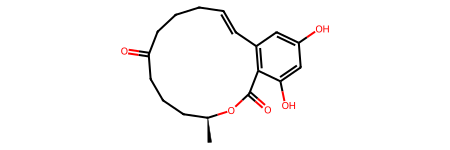

In [9]:
chosen_rec = data_repeated_sieved[30.0]["MBMQEIFVQACCCH"]["Orbitrap"]
Chem.MolFromSmiles(chosen_rec[0].metadata["smiles"])

Get similarity of MS across different instruments and same instrument

 47%|████▋     | 272/583 [00:00<00:00, 475.67it/s]

arrays used as indices must be of integer (or boolean) type


100%|██████████| 583/583 [00:01<00:00, 563.75it/s]


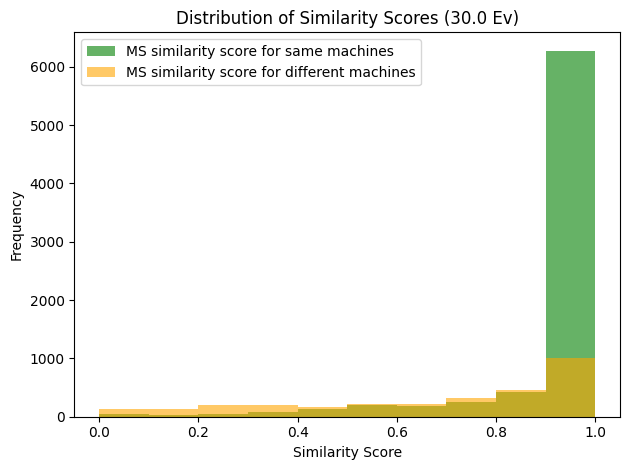

100%|██████████| 846/846 [00:00<00:00, 1012.24it/s]


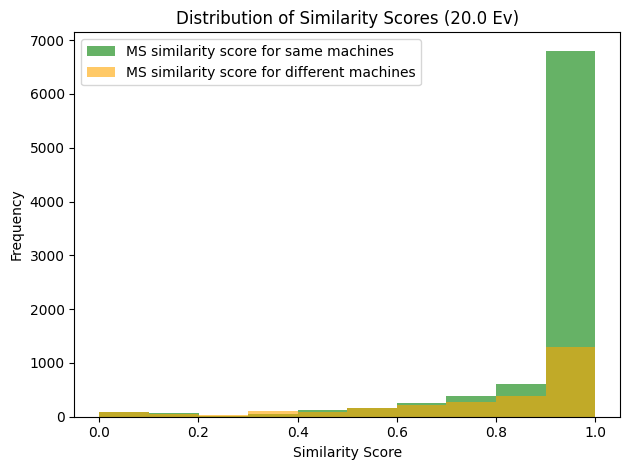

100%|██████████| 119/119 [00:00<00:00, 1070.96it/s]


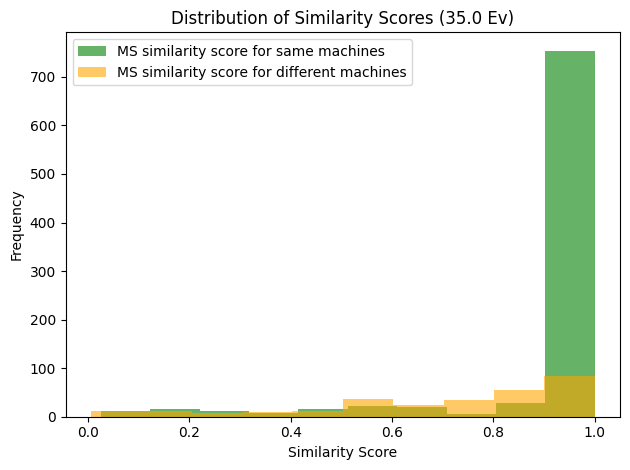

100%|██████████| 324/324 [00:00<00:00, 1112.91it/s]


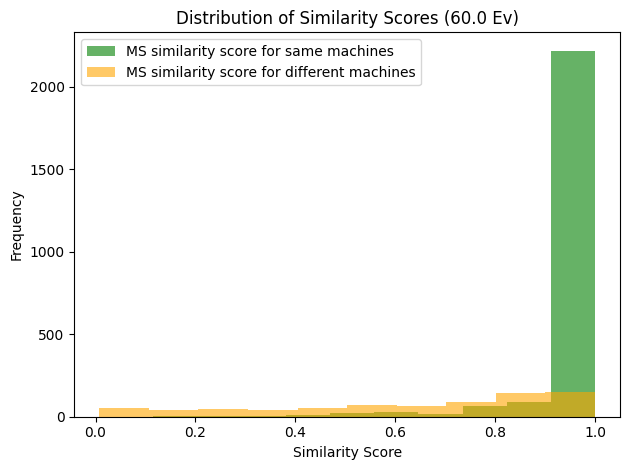

100%|██████████| 153/153 [00:00<00:00, 1123.19it/s]


arrays used as indices must be of integer (or boolean) type


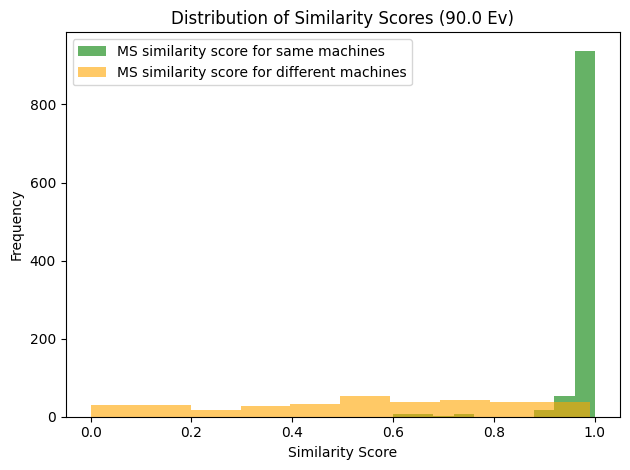

In [17]:
energies = [energy for energy, rec in data_repeated_sieved.items() if len(rec) >= 100]

same_instrument_similarity_all_energy = []
diff_instrument_similarity_all_energy = []

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_score(score)

                    if i == j: 
                        same_instrument_similarity.extend(score)
                    else:
                        diff_instrument_similarity.extend(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    same_instrument_similarity_all_energy.extend(same_instrument_similarity_all)
    diff_instrument_similarity_all_energy.extend(diff_instrument_similarity_all)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores ({energy} Ev)')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev.png"),bbox_inches='tight')
    plt.show()

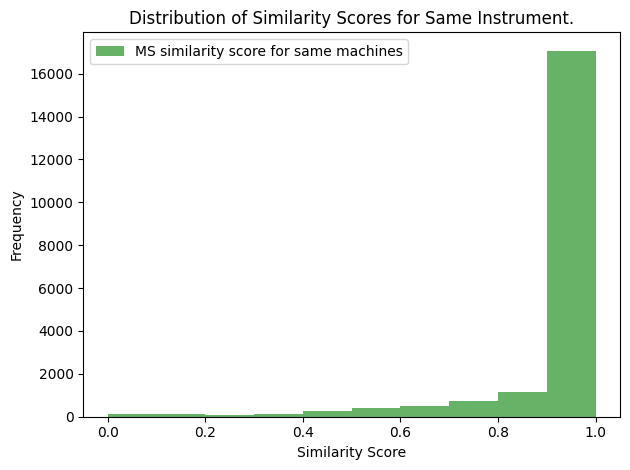

In [18]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(same_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
# axs.hist(diff_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

# Add labels and title
axs.set_xlabel('Similarity Score')
axs.set_ylabel('Frequency')
axs.set_title(f'Distribution of Similarity Scores for Same Instrument.')
axs.legend()  # Display the legend to distinguish the distributions
plt.savefig(os.path.join(plots_folder, f"similarity_same_machine_merged.png"))
plt.show()

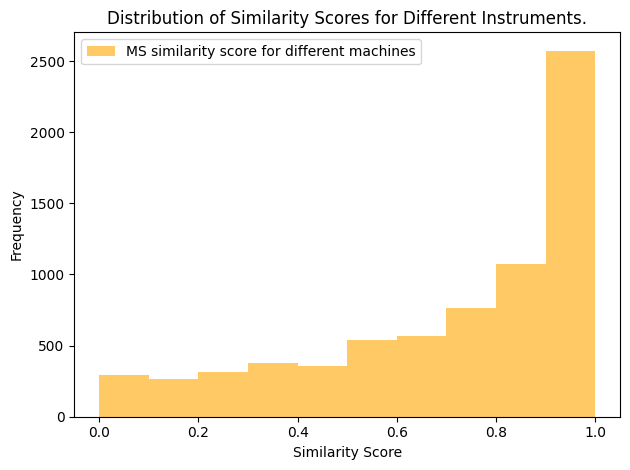

In [19]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
# axs.hist(same_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
axs.hist(diff_instrument_similarity_all_energy, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

# Add labels and title
axs.set_xlabel('Similarity Score')
axs.set_ylabel('Frequency')
axs.set_title(f'Distribution of Similarity Scores for Different Instruments.')
axs.legend()  # Display the legend to distinguish the distributions
plt.savefig(os.path.join(plots_folder, f"similarity_different_machines_merged.png"))
plt.show()

Check if the similarity score can be improved by removing low intensity peaks

In [20]:
data_repeated_sieved_remove_peaks_005 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_005: data_repeated_sieved_remove_peaks_005[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_005[energy]: data_repeated_sieved_remove_peaks_005[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.05) for s in spec]
            data_repeated_sieved_remove_peaks_005[energy][inchikey][instrument] = spec_list


data_repeated_sieved_remove_peaks_010 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_010: data_repeated_sieved_remove_peaks_010[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_010[energy]: data_repeated_sieved_remove_peaks_010[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.10) for s in spec]
            data_repeated_sieved_remove_peaks_010[energy][inchikey][instrument] = spec_list


data_repeated_sieved_remove_peaks_015 = {}

for energy, rec in data_repeated_sieved.items(): 

    if energy not in data_repeated_sieved_remove_peaks_015: data_repeated_sieved_remove_peaks_015[energy] = {} 

    for inchikey, rec_2 in rec.items(): 
        
        if inchikey not in data_repeated_sieved_remove_peaks_015[energy]: data_repeated_sieved_remove_peaks_015[energy][inchikey] = {}
        
        for instrument, spec in rec_2.items():

            spec_list = [select_by_intensity(s, intensity_from = 0.15) for s in spec]
            data_repeated_sieved_remove_peaks_015[energy][inchikey][instrument] = spec_list


 20%|██        | 118/583 [00:00<00:00, 603.08it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 50%|████▉     | 290/583 [00:00<00:00, 781.55it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 583/583 [00:00<00:00, 924.20it/s] 


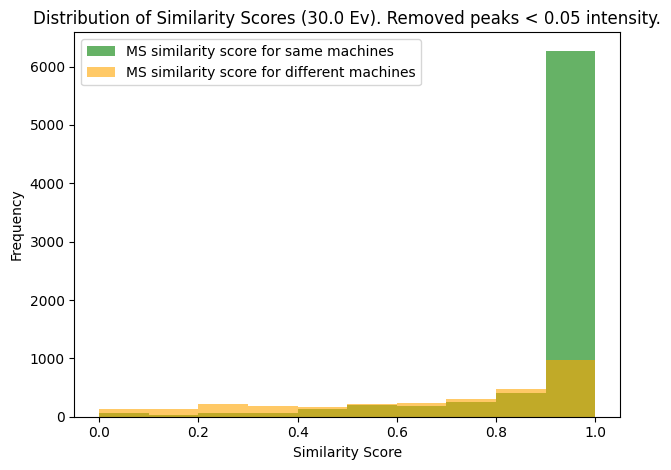

 13%|█▎        | 111/846 [00:00<00:01, 559.23it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 42%|████▏     | 359/846 [00:00<00:00, 1041.30it/s]

arrays used as indices must be of integer (or boolean) type


100%|██████████| 846/846 [00:00<00:00, 1337.21it/s]


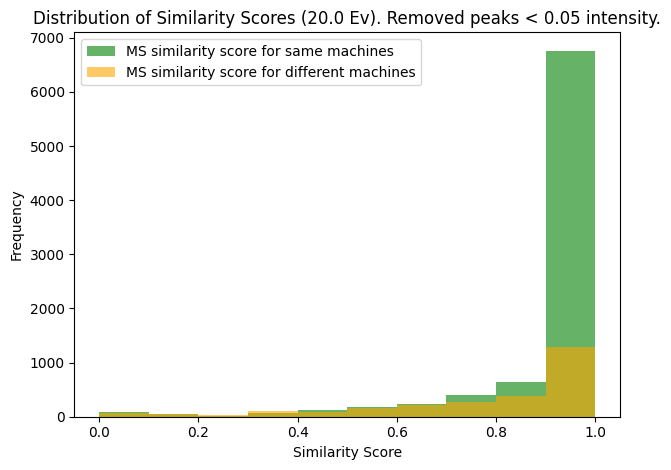

100%|██████████| 119/119 [00:00<00:00, 1678.88it/s]


arrays used as indices must be of integer (or boolean) type


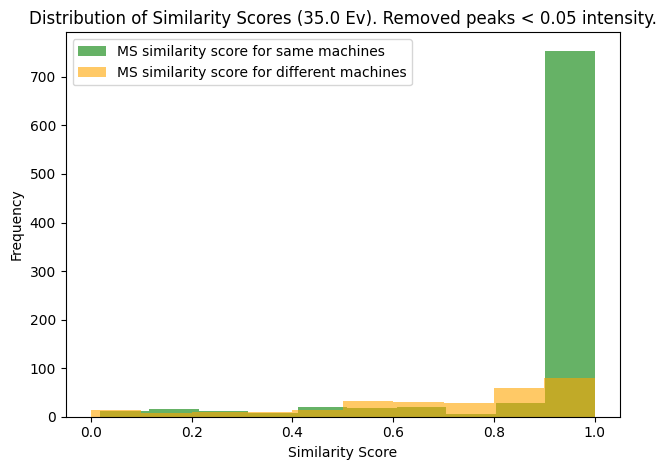

100%|██████████| 324/324 [00:00<00:00, 1629.43it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


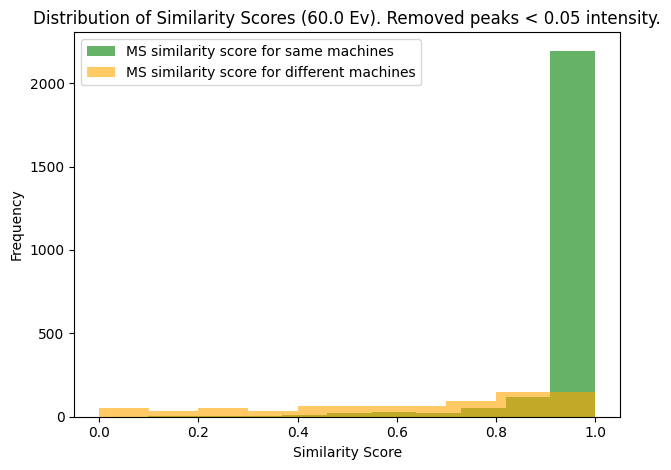

100%|██████████| 153/153 [00:00<00:00, 1612.83it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


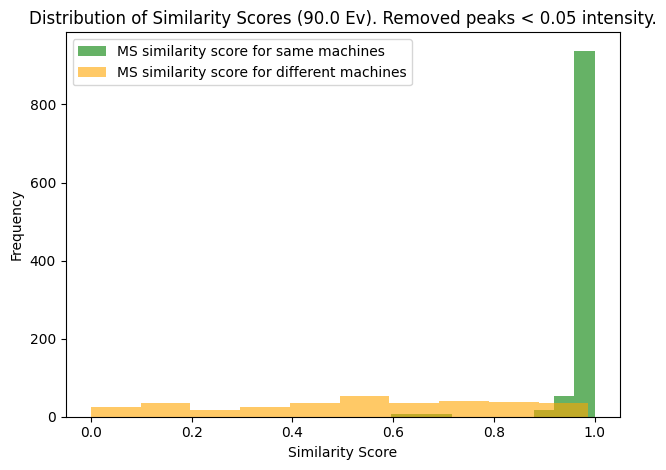

In [21]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_005.items() if len(rec) >= 100] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_005[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_score(score)

                    if i == j: 
                        same_instrument_similarity.extend(score)
                    else:
                        diff_instrument_similarity.extend(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores ({energy} Ev). Removed peaks < 0.05 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_005.png"), bbox_inches='tight')
    plt.show()

 13%|█▎        | 77/583 [00:00<00:01, 382.69it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 46%|████▌     | 269/583 [00:00<00:00, 624.78it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 583/583 [00:00<00:00, 772.72it/s]

arrays used as indices must be of integer (or boolean) type


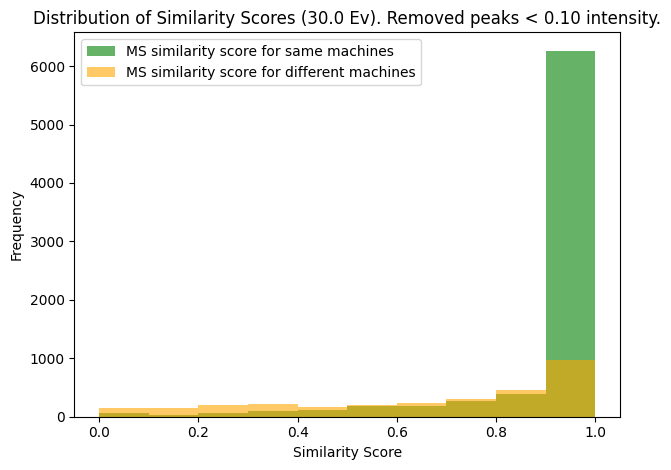

 14%|█▍        | 119/846 [00:00<00:01, 597.54it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 43%|████▎     | 368/846 [00:00<00:00, 1049.84it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 846/846 [00:00<00:00, 1342.21it/s]


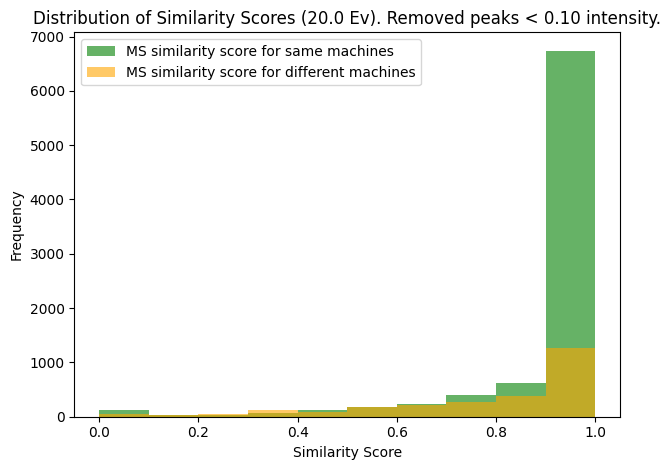

In [23]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_010.items() if len(rec) >= 500] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_010[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_score(score)

                    if i == j: 
                        same_instrument_similarity.extend(score)
                    else:
                        diff_instrument_similarity.extend(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores ({energy} Ev). Removed peaks < 0.10 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_010.png"), bbox_inches='tight')
    plt.show()

  0%|          | 0/583 [00:00<?, ?it/s]

 12%|█▏        | 69/583 [00:00<00:01, 340.58it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 36%|███▋      | 212/583 [00:00<00:00, 448.46it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 68%|██████▊   | 396/583 [00:00<00:00, 735.32it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 583/583 [00:00<00:00, 687.23it/s]


arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


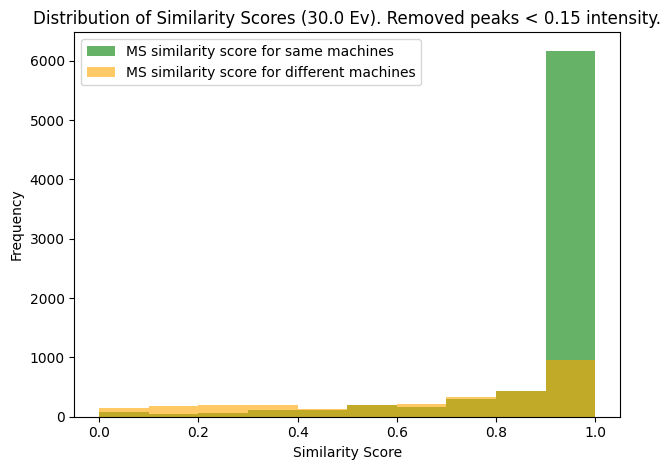

 15%|█▍        | 126/846 [00:00<00:01, 642.02it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


 44%|████▍     | 371/846 [00:00<00:00, 1046.07it/s]

arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type


100%|██████████| 846/846 [00:00<00:00, 1395.78it/s]


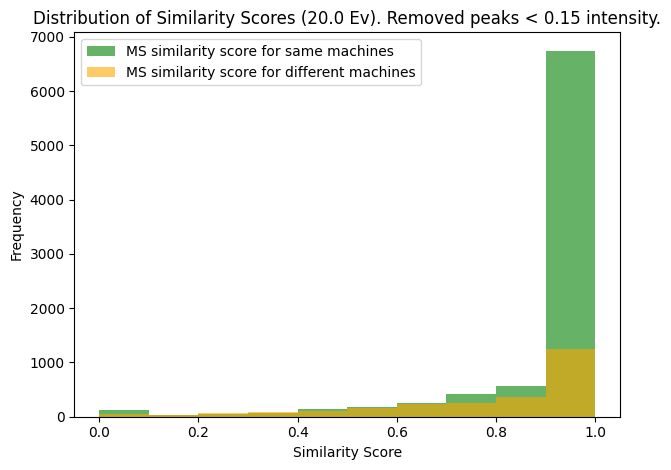

In [24]:
energies = [energy for energy, rec in data_repeated_sieved_remove_peaks_015.items() if len(rec) >= 500] 

for energy in energies:

    data_repeated_sieved_e = data_repeated_sieved_remove_peaks_015[energy]
    same_instrument_similarity_all = []
    diff_instrument_similarity_all = []

    for k, rec in tqdm(data_repeated_sieved_e.items()):

        instruments = list(rec.keys())

        same_instrument_similarity = []
        diff_instrument_similarity = []

        for i in range(len(instruments)):

            instrument_i = instruments[i]

            try:
                for j in range(i, len(instruments)):
                    
                    instrument_j = instruments[j]

                    score = calculate_scores(rec[instrument_i], rec[instrument_j], greedy_cs)
                    score = unpack_score(score)

                    if i == j: 
                        same_instrument_similarity.extend(score)
                    else:
                        diff_instrument_similarity.extend(score)

            except Exception as e: 
                print(e)
                continue

        same_instrument_similarity_all.extend(same_instrument_similarity)
        diff_instrument_similarity_all.extend(diff_instrument_similarity)

    fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
    axs.hist(same_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for same machines", color = "green")
    axs.hist(diff_instrument_similarity_all, alpha = 0.6, label = "MS similarity score for different machines", color = "orange")

    # Add labels and title
    axs.set_xlabel('Similarity Score')
    axs.set_ylabel('Frequency')
    axs.set_title(f'Distribution of Similarity Scores ({energy} Ev). Removed peaks < 0.15 intensity.')
    axs.legend()  # Display the legend to distinguish the distributions
    plt.savefig(os.path.join(plots_folder, f"similarity_across_machines_{energy}_ev_015.png"), bbox_inches='tight')
    plt.show()